In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from datetime import datetime, time
from prophet import Prophet
import glob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

In [ ]:
def display_errors(y_true, y_pred, return_vals=False):
    mse = mean_squared_error(y_true, y_pred)
    print(f"MSE: {round(mse, 3)}")
    rmse = mse ** 0.5
    print(f"RMSE: {round(rmse, 3)}")
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE: {round(mae, 3)}")
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"MAPE: {round(mape, 3)}")
    r2 = r2_score(y_true, y_pred)
    print(f"R2: {round(r2, 3)}")

    if return_vals:
        return [mse, rmse, mae, mape, r2]

def plot_errors(y_true, y_pred, name='N/A'):
    plt.scatter(y_true, y_pred, color='blue', marker='o', label=f'error adjusted predictions ({name}) vs actual degree days')
    plt.xlabel('actual degree days')
    plt.ylabel('predicted degree days')
    plt.title(f'Prediction vs Actual ({name})')

    max_value = max(max(y_true[-225:]), max(y_true[-225:]))
    min_value = min(min(y_true[-225:]), min(y_true[-225:]))
    plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

    plt.legend()


In [82]:
# obtain and sort required raw data
degree_days = 'pw_cdd' # 'gw_hdd', 'ew_cdd' or 'pw_cdd'
path = "RawData"

def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    extracted_date = parts[1]
    extracted_time = parts[2]
    return extracted_date, extracted_time

def get_date(file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param file: filename containing the time
    :return: datetime object
    """

    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    date_value = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date_value.date(), time_value)
    return combined_datetime

degree_days = degree_days
ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_ens_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
ecmwf_ens_sorted_files = sorted(ecmwf_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_ens_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                              extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                              extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if
                            extract_date_time(filename) in master_set]

### process raw data into individual components for model

In [83]:
# y
# euro ensemble - values to predict
ecmwf_ens_9_14 = pd.DataFrame(columns=['ens(9,14)'])

for i in range(1, len(ecmwf_ens_sorted_files)):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_ens_sorted_files[i])
    prev_date = get_date(ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_ens_df['Value'].iloc[8:14].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(14+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_ens_9_14.columns, index=[date])
    ecmwf_ens_9_14 = pd.concat([ecmwf_ens_9_14, new_row])

In [84]:
# X1
# euro ensemble day 8
ecmwf_ens_8 = pd.DataFrame(columns=['ens(8)'])

for i in range(1, len(ecmwf_ens_sorted_files)):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_ens_sorted_files[i])
    prev_date = get_date(ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_ens_df['Value'].iloc[7:8].sum() #7-8 benchmark, 7-8 best results
    prev = prev_ecmwf_ens_df['Value'].iloc[(7+offset):(8+offset)].sum() #7-8 benchmark, 7-8 best results
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_ens_8.columns, index=[date])
    ecmwf_ens_8 = pd.concat([ecmwf_ens_8, new_row])

In [85]:
# X2
# ecmwf(9,10) - ecmwf_ens-1(9,10)

ecmwf_9_10 = pd.DataFrame(columns=['ecmwf(9)'])

for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_sorted_files[i])
    prev_date = get_date(ecmwf_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    #cur = ecmwf_df['Value'].iloc[8:10].sum()
    #prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(10+offset)].sum()

    cur = ecmwf_df['Value'].iloc[8:9].sum() #8-9 benchmark, 4-9 best results
    prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(9+offset)].sum() #8-9 benchmark, 4-9 best results

    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_9_10.columns, index=[date])
    ecmwf_9_10 = pd.concat([ecmwf_9_10, new_row])

In [86]:
# X3
# gfs(11,14) - ecmwf_ens-1(11,14)

gfs_11_14 = pd.DataFrame(columns=['gfs(10,14)'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(gfs_ens_bc_sorted_files[i])
    prev_date = get_date(ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    #cur = gfs_df['Value'].iloc[10:14].sum()
    #prev = prev_ecmwf_ens_df['Value'].iloc[(10+offset):(14+offset)].sum()

    cur = gfs_df['Value'].iloc[9:14].sum() # 9-14 benchmark, 9-16 best results
    prev = prev_ecmwf_ens_df['Value'].iloc[(9+offset):(14+offset)].sum() # 9-14 benchmark, 9-16 best results

    change = cur - prev

    new_row = pd.DataFrame(change, columns=gfs_11_14.columns, index=[date])
    gfs_11_14 = pd.concat([gfs_11_14, new_row])

In [87]:
# X4
# cmc(9,14) - gfs(9,14)

cmc_9_14 = pd.DataFrame(columns=['cmc(9,15)'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_df = pd.read_csv(cmc_ens_sorted_files[i])
    cmc_df = cmc_df[cmc_df[cmc_df.columns[2]] >= 1]
    gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]

    date = get_date(cmc_ens_sorted_files[i])

    cmc = cmc_df['Value'].iloc[8:14].sum() #8-14 benchmark, 8-14 best results
    gfs = gfs_df['Value'].iloc[8:14].sum() #8-14 benchmark, 8-14 best results
    change = cmc - gfs

    new_row = pd.DataFrame(change, columns=cmc_9_14.columns, index=[date])
    cmc_9_14 = pd.concat([cmc_9_14, new_row])

In [88]:
norms = pd.DataFrame(columns=['Date', 'Value'])
for i in range(1, len(ecmwf_ens_sorted_files), 2):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    v1 = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] == 2].iloc[:, :2]
    norms = pd.concat([norms, v1]).drop_duplicates('Date')

norms.reset_index(inplace=True)
norms.drop(columns=['index'], inplace=True)
norms['Date'] = pd.to_datetime(norms['Date']).dt.strftime('%Y-%m-%d 12:00:00')
norms.set_index('Date', inplace=True)
norms.rename_axis('', inplace=True)
norms.rename(columns={'Value': 'norm'}, inplace=True)

# testing

In [89]:
i = 0

d1 = gfs_ens_bc_sorted_files[i].split('.')[1]
d2 = ecmwf_ens_sorted_files[i-1].split('.')[1]

gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
v1 = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]
prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
v2 = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

In [ ]:
print(ecmwf_ens_sorted_files[i])
print(ecmwf_ens_sorted_files[i - 1])

In [ ]:
if d1 == d2:
    offset = 1
else:
    offset = 0

In [ ]:
a = v1.iloc[9:14]

In [ ]:
b = v2.iloc[9+offset:14+offset]

In [ ]:
a['Value'].sum() - b['Value'].sum()

In [ ]:
display(a)

In [ ]:
display(b)

In [ ]:
display(v1)

In [ ]:
display(v2)

In [ ]:
display(ecmwf_ens_8.head())

# model

In [90]:
master_df = pd.concat([ecmwf_ens_9_14, ecmwf_ens_8, ecmwf_9_10, gfs_11_14, cmc_9_14], axis=1)

In [91]:
master_df

,"ens(9,14)",ens(8),ecmwf(9),"gfs(10,14)","cmc(9,15)"
2018-07-11 00:00:00,2.877,0.319,0.042,-3.368,5.916
2018-07-11 12:00:00,-3.078,-0.758,-2.872,-5.642,7.999
2018-07-12 00:00:00,2.098,0.421,0.113,-4.954,9.857
2018-07-12 12:00:00,2.066,0.651,0.107,-7.224,6.698
2018-07-13 00:00:00,-3.090,-0.214,-0.241,-8.854,5.458
...,...,...,...,...,...
2023-05-15 00:00:00,-0.230,-0.199,-0.966,5.747,-1.123
2023-05-15 12:00:00,0.192,0.270,-0.774,6.822,-0.814
2023-05-16 00:00:00,-0.296,-0.069,-0.273,7.352,-1.724
2023-05-16 12:00:00,-0.606,-0.122,-0.019,9.699,-3.183


In [92]:
data = master_df.copy()

In [93]:
#get only noon forecast
data['hour'] = data.index.hour
data = data[data['hour'] == 12]
data.drop('hour', axis=1, inplace=True)

In [94]:
data.index = pd.to_datetime(data.index)
norms.index = pd.to_datetime(norms.index)
data = pd.merge(data, norms, left_index=True, right_index=True)
data = data.dropna()

In [95]:
display(data.columns)

Index(['ens(9,14)', 'ens(8)', 'ecmwf(9)', 'gfs(10,14)', 'cmc(9,15)', 'norm'], dtype='object')

In [96]:
if 'hdd' in degree_days:
    print('getting betas for hdd')
    b1 = 0.76947604258751
    b2 = 0.6555933110283885
    b3 = 0.16964083221789059
    b4 = 0.06680336217511197

else:
    print('getting betas for cdd')
    b1 = 1.7687808214521186
    b2 =0.42218026473687276
    b3 = 0.1128916050374201
    b4 = 0.08538981339364801

getting betas for cdd


In [97]:
features = ['ens(8)', 'ecmwf(9)', 'gfs(10,14)', 'cmc(9,15)', 'norm']
X = data[features]

In [98]:
display(X)

,ens(8),ecmwf(9),"gfs(10,14)","cmc(9,15)",norm
2018-07-26 12:00:00,-0.452,0.176,-6.246,6.657,11.920
2018-07-27 12:00:00,0.196,0.459,-5.494,5.330,11.883
2018-07-28 12:00:00,0.107,-0.312,-6.272,8.416,11.841
2018-07-29 12:00:00,0.063,0.694,-6.948,7.040,11.795
2018-07-30 12:00:00,0.211,-0.982,-0.465,4.825,11.745
...,...,...,...,...,...
2023-05-12 12:00:00,0.310,0.630,5.248,1.457,3.583
2023-05-13 12:00:00,-0.273,-0.032,3.151,-0.496,3.727
2023-05-14 12:00:00,0.114,0.006,5.081,1.353,3.875
2023-05-15 12:00:00,0.270,-0.774,6.822,-0.814,4.025


In [99]:
label = 'ens(9,14)'
y = data[label]

In [100]:
y

2018-07-26 12:00:00    0.010
2018-07-27 12:00:00    1.238
2018-07-28 12:00:00    2.065
2018-07-29 12:00:00   -0.340
2018-07-30 12:00:00    0.621
                       ...  
2023-05-12 12:00:00   -0.442
2023-05-13 12:00:00    0.077
2023-05-14 12:00:00   -0.529
2023-05-15 12:00:00    0.192
2023-05-16 12:00:00   -0.606
Name: ens(9,14), Length: 1732, dtype: float64

In [ ]:
regression_preds = (b1 * X.iloc[:,0]) + (b2 * X.iloc[:,1]) + (b3 * X.iloc[:,2]) + (b4 * X.iloc[:,3])

In [ ]:
y[-225:]

In [ ]:
base_predictions_df = pd.DataFrame({'actual': y[-225:], 'prediction': regression_preds[-225:]})

In [ ]:
forecasting_errors = y - regression_preds
mean_error = forecasting_errors[:-225].mean()

In [ ]:
print('errors before any adjustments (benchmark)')
error_vals = display_errors(y[-225:], regression_preds[-225:] + mean_error, return_vals=True)

In [ ]:
display_errors(y[:-225], regression_preds[:-225])

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['metrics', 'error before adjustments'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["MSE", "RMSE", "MAE", "MAPE", "R2"],
                       error_vals], # 2nd column
               line_color='darkslategray',
               fill_color='darkcyan',
               align='left'))
])

fig.update_layout(width=500, height=400)
#fig.write_image('images/linear_regression_errors_before_adjustments_table.png')
fig.show()

In [ ]:
fig = px.scatter(
    base_predictions_df, x='actual', y='prediction',
    marginal_x='histogram', marginal_y='histogram', trendline='ols',
    title='Linear Regression Prediction (No Adjustments) vs Actual'
)
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y[-225:].min(), y0=y[-225:].min(),
    x1=y[-225:].max(), y1=y[-225:].max()
)
fig.show()
#fig.write_image('images/linear_regression_prediction_vs_actual.png')

In [ ]:
forecasting_errors = y - regression_preds
mean_error = forecasting_errors[:-225].mean()
mean_error

In [ ]:
plt.plot(forecasting_errors[-225:])

In [ ]:
mean_error = forecasting_errors[:-225].mean()
mse = mean_squared_error(y[-225:], regression_preds[-225:] + mean_error)
print(mse)

# creating new lin reg model to predict degree days directly

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [111]:
season_start = '2020-06-01 12:00:00'
season_end = '2020-10-29 12:00:00'
X_test = X.loc[season_start: season_end]
y_test = y.loc[season_start: season_end]

#remove X_test from dataframe to get X_train
mask = (X.index >= season_start) & (X.index <= season_end)
X_train = X.loc[~mask]
y_train = y.loc[~mask]


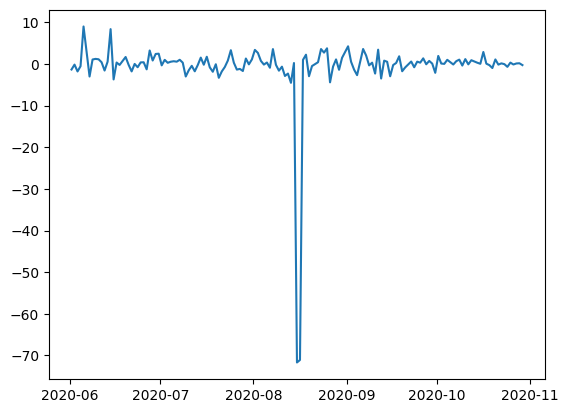

In [122]:
plt.plot(y_test)

In [112]:
y_train.tail()

2023-05-12 12:00:00   -0.442
2023-05-13 12:00:00    0.077
2023-05-14 12:00:00   -0.529
2023-05-15 12:00:00    0.192
2023-05-16 12:00:00   -0.606
Name: ens(9,14), dtype: float64

In [113]:
model = LinearRegression(fit_intercept=True).fit(X_train, y_train)

In [114]:
print(model.coef_)
print(model.intercept_)

[1.29883581 0.4978322  0.1519734  0.11544759 0.01207974]
-0.18615839367114978


In [115]:
print("linear regression formula:")
print(f"y = {model.intercept_} + {model.coef_[0]}*x1 + {model.coef_[1]}*x2 + {model.coef_[2]}*x3 + {model.coef_[3]}*x4")

linear regression formula:
y = -0.18615839367114978 + 1.2988358066337504*x1 + 0.4978322033179757*x2 + 0.15197339517418013*x3 + 0.11544758885539844*x4


In [116]:
preds = model.predict(X_test)

In [117]:
mean_error = (y_train - model.predict(X_train)).mean()

In [118]:
mean_error

0.0

In [119]:
print('errors for new lin reg model:')
#error_vals_adj = display_errors(y_test[-225:], preds[-225:], return_vals=True)
error_vals_adj = display_errors(y_test, preds, return_vals=True)

errors for new lin reg model:
MSE: 26.417
RMSE: 5.14
MAE: 1.797
MAPE: 2.021
R2: 0.645


In [120]:
display_errors(y_train, model.predict(X_train))

MSE: 1.45
RMSE: 1.204
MAE: 0.746
MAPE: 1124439249885.318
R2: 0.253


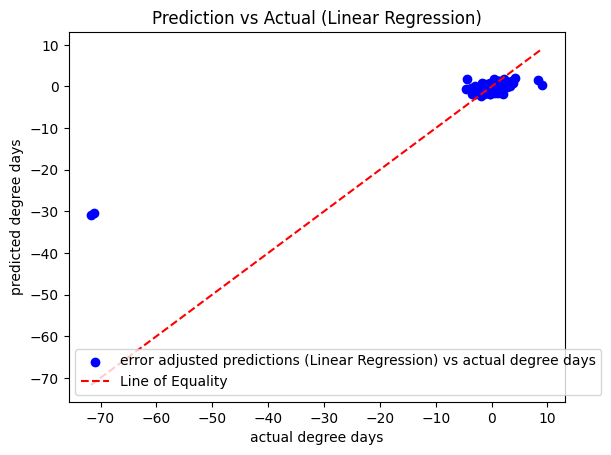

In [121]:
plot_errors(y_test, preds, 'Linear Regression')

In [ ]:
model_preds_df = pd.DataFrame({'actual': y[-225:], 'prediction': preds[-225:]})

fig = px.scatter(
    model_preds_df, x='actual', y='prediction',
    marginal_x='histogram', marginal_y='histogram', trendline='ols',
    title="adjusted model (linear regression) vs actual degree days"
)
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max()
)
fig.show()
fig.write_image('images/linear_regression_prediction_vs_actual_after_adj.png')

In [ ]:
snippet_train = X_train[-35:-30]
fig = go.Figure(data=[go.Table(
    header=dict(values=['date', 'ens(8)', 'ecmwf(9)', 'gfs(10,14)', 'cmc(9,15)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[snippet_train.index, round(snippet_train['ens(8)'], 3), round(snippet_train['ecmwf(9)'], 3),
                       round(snippet_train['gfs(10,14)'], 3), round(snippet_train['cmc(9,15)'], 3)],
               fill_color='darkcyan',
               align='left'))
])
fig.show()
#fig.write_image('images/linear_regression_snippet_train.png')

y_train_snippet = y_train[-35:-30]

fig = go.Figure(data=[go.Table(
    header=dict(values=['date', 'ens(9,14)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[snippet_train.index, round(y_train_snippet, 3)],
               fill_color='darkcyan',
               align='left'))
])
fig.show()
#fig.write_image('images/linear_regression_snippet_train_y.png')

### forecasting errors linear regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, forecasting_errors,
                                                    test_size=0.15, shuffle=False)

In [ ]:
display(y[-225:])

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
print(reg.coef_)
print(reg.intercept_)

In [ ]:
print("linear regression formula:")
print(f"y = {reg.intercept_} + {reg.coef_[0]}*x1 + {reg.coef_[1]}*x2 + {reg.coef_[2]}*x3 + {reg.coef_[3]}*x4")

In [ ]:
error_preds = reg.predict(X_test)

In [ ]:
print('errors for linear regression adjusted model:')
error_vals_adj = display_errors(y[-225:], error_preds[-225:] + regression_preds[-225:], return_vals=True)

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['metrics', 'error before adjustments'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["MSE", "RMSE", "MAE", "MAPE", "R2"],
                       error_vals_adj], # 2nd column
               line_color='darkslategray',
               fill_color='darkcyan',
               align='left'))
])

fig.update_layout(width=500, height=400)
fig.write_image('images/linear_regression_errors_after_adjustments_table.png')
fig.show()

In [ ]:
plot_errors(y[-225:], error_preds[-225:] + regression_preds[-225:], 'Linear Regression')

In [ ]:
err_adjusted = y[-225:] - (error_preds[-225:] + regression_preds[-225:])
err_no_adj = y[-225:] - regression_preds[-225:]

plt.hist(err_adjusted, bins=20, alpha=0.5, label='adjusted', color='green')
plt.hist(err_no_adj, bins=20, alpha=0.5, label='non-adjusted', color='blue')
plt.xlabel('error')
plt.ylabel('frequency')
plt.title('Distribution of errors (adjusted and non-adjusted)')
plt.legend()
plt.show()

In [ ]:
colors = ['Positive' if c > 0 else 'Negative' for c in reg.coef_]

fig = px.bar(
    x=X_train.columns, y=reg.coef_, color=colors,
    color_discrete_sequence=['green', 'red'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for error prediction'
)
fig.show()
fig.write_image('images/linear_regression_coefficients.png')

In [ ]:
prediction_df = X_test.iloc[-225:].copy()
prediction_df['actual'] = y[-225:]
prediction_df['prediction'] = (error_preds[-225:] + regression_preds[-225:])

In [ ]:
fig = px.scatter(
    prediction_df, x='actual', y='prediction',
    marginal_x='histogram', marginal_y='histogram', trendline='ols',
    title="adjusted model (linear regression) vs actual degree days"
)
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max()
)
fig.show()
fig.write_image('images/linear_regression_prediction_vs_actual_after_adj.png')

In [ ]:
# remove 2 coefficients that are not statistically significant
y_preds = (0.4549100528456273 * X.iloc[:,0]) + (-0.404531307635968 * X.iloc[:,1]) + reg.intercept_

In [ ]:
mse_all_vals = mean_squared_error(forecasting_errors[-225:], error_preds[-225:])
print(mse_all_vals)
mse_2_coef = mean_squared_error(forecasting_errors[-225:], y_preds[-225:])
print(mse_2_coef)

In [ ]:
plt.scatter(forecasting_errors[-225:], error_preds[-225:], color='blue', marker='o', label='predictions vs actual')
plt.xlabel('actual error')
plt.ylabel('predicted error')
plt.title('Prediction vs Actual (Linear Regression)')

max_value = max(max(y[-225:]), max(error_preds[-225:]))
min_value = min(min(y[-225:]), min(error_preds[-225:]))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

plt.legend()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn_dist = KNeighborsRegressor(2, weights='distance')
knn_dist.fit(X_train, y_train)
y_dist = knn_dist.predict(X_test)

knn_uni = KNeighborsRegressor(2, weights='uniform')
knn_uni.fit(X_train, y_train)
y_uni = knn_uni.predict(X_test)

In [ ]:
fig = px.scatter(x=y_test[-225:], y=y_dist[-225:], opacity=0.65)
X_range = np.linspace(y_test[-225:].min(), y_test[-225:].max(), 100)
fig.add_traces(go.Scatter(x=X_range, y=y_dist[-225:], name='Weights: Distance'))
fig.add_traces(go.Scatter(x=X_range, y=y_uni[-225:], name='Weights: Uniform'))

In [ ]:
print('errors for knn distance model:')
display_errors(y_test[-225:], y_dist[-225:] + regression_preds[-225:])
print('errors for knn uniform model:')
display_errors(y_test[-225:], y_uni[-225:] + regression_preds[-225:])

In [ ]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(forecasting_errors.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(forecasting_errors, lags=40, ax=ax2)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(forecasting_errors, trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
start_date = '2022-10-04'
end_date = '2023-05-16'
predict = res.predict(start=start_date, end=end_date)

In [ ]:
predict

In [ ]:
mse_SM = mean_squared_error(y[-225:], predict + regression_preds[-225:])
print(f"MSE after adjustment (SARIMAX): {mse_SM}") # MSE after adjustments (sarimax)

### forecasting errors - prophet

In [ ]:
errors = forecasting_errors.to_frame()
errors['ds'] = errors.index
errors.rename(columns={0:'y'}, inplace=True)
errors.reset_index(drop=True, inplace=True)

In [ ]:
train_len = 0.85
train_errors = errors.iloc[:int(len(errors)*train_len)]
test_errors = errors.iloc[int(len(errors)*train_len):]

In [ ]:
m = Prophet()
m.fit(train_errors)

In [ ]:
future = m.make_future_dataframe(periods=263)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
forecasted_errors = forecast[['ds', 'yhat']]
forecasted_errors.set_index('ds', inplace=True)

In [ ]:
# errors without adjustment
((regression_preds[-225:] - y[-225:]) **2).mean()

In [ ]:
# errors with prophet adjustment
(((regression_preds[-225:] + forecasted_errors['yhat'][-225:]) - y[-225:])**2).mean()

### forecasting errors - autogluon

In [ ]:
data_df = data.copy()

In [ ]:
data_df['errors'] = forecasting_errors

In [ ]:
data_df.drop('ens(9,14)', axis=1, inplace=True)

In [ ]:
label = 'errors'
features = ['ens(8)', 'ecmwf(9,10)', 'gfs(11,14)', 'cmc(9,14)']

In [ ]:
train_len = 0.85

In [ ]:
train_data = TabularDataset(data_df.iloc[:int(len(data_df)*train_len)])
test_data = TabularDataset(data_df.iloc[int(len(data_df)*train_len):])

In [ ]:
train_data

In [ ]:
test_data

In [ ]:
predictor = TabularPredictor(label=label).fit(train_data, presets='best_quality')

In [ ]:
test_data_no_lab = test_data.drop(columns=[label])
test_data_no_lab

In [ ]:
error_pred = predictor.predict(test_data_no_lab)
error_pred.head()

In [ ]:
predictor.evaluate(test_data, silent=True)

In [ ]:
print("errors after adjustment (AutoGluon):")
display_errors(y[-225:], error_pred[-225:] + regression_preds[-225:])

In [ ]:
plt.scatter(y[-225:], error_pred[-225:], color='blue', marker='o', label='predictions vs actual')
plt.xlabel('actual error')
plt.ylabel('predicted error')
plt.title('Prediction vs Actual (Deep Learning)')

max_value = max(max(y[-225:]), max(error_pred[-225:]))
min_value = min(min(y[-225:]), min(error_pred[-225:]))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

plt.legend()

In [ ]:
predictor.leaderboard(silent=True)

In [ ]:
predictor.feature_importance(test_data)

In [ ]:
import xgboost as xgb

In [ ]:
label_df = train_data[label]
train_data = train_data[features]

In [ ]:
dtrain = xgb.DMatrix(train_data, label=label_df)

In [ ]:
bst = xgb.train(params={'objective': 'reg:squarederror'}, dtrain=dtrain)

In [ ]:
test_data = test_data[features]

In [ ]:
dtest = xgb.DMatrix(test_data)
ypred = bst.predict(dtest)

In [ ]:
# MSE after xgboost adjustment
mse_XGB = (((ypred[-225:] + regression_preds[-225:]) - y[-225:]) ** 2).mean()
print(f"MSE after adjustment (XGBoost): {mse_XGB}")

In [ ]:
xgb.plot_importance(bst)

### improving model through deep learning

In [ ]:
deep_preds = pd.read_pickle("predictions.pkl")

In [ ]:
deep_preds = deep_preds.to_frame()

In [ ]:
deep_preds.rename(columns={0:'prediction'}, inplace=True)

In [ ]:
y = y.to_frame()

In [ ]:
#combine deep_pred and y
deep_preds['y'] = y['ens(9,14)']

In [ ]:
deep_preds.dropna(inplace=True)

In [ ]:
# MSE of custom deep learning model
mse_DL = ((deep_preds[deep_preds.columns[0]][-225:] - deep_preds[deep_preds.columns[1]][-225:])**2).mean()
print(f"MSE after adjustment (Deep Learning): {mse_DL}")

In [ ]:
display_errors(deep_preds[deep_preds.columns[1]][-225:], deep_preds[deep_preds.columns[0]][-225:])

In [ ]:
plt.scatter(deep_preds[deep_preds.columns[0]][-225:], deep_preds[deep_preds.columns[1]][-225:], color='blue', marker='o', label='predictions vs actual')
plt.xlabel('actual degree days')
plt.ylabel('predicted degree days')
plt.title('Prediction vs Actual (custom model)')

max_value = max(max(deep_preds[deep_preds.columns[1]][-225:]), max(deep_preds[deep_preds.columns[0]][-225:]))
min_value = min(min(deep_preds[deep_preds.columns[1]][-225:]), min(deep_preds[deep_preds.columns[0]][-225:]))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

plt.legend()

In [ ]:
deep_preds[deep_preds.columns[0]][-225:]

In [ ]:
fig = px.scatter(
    deep_preds[-225:], x='y', y='prediction',
    marginal_x='histogram', marginal_y='histogram', trendline='ols'
)
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max()
)

fig.show()

In [ ]:
display_errors(deep_preds[deep_preds.columns[0]][-225:], deep_preds[deep_preds.columns[1]][-225:])

# graphs between dependent variable and indedpendant variables

In [ ]:
display(X)

In [ ]:
plt.scatter(X.iloc[:, 0], y, color='blue', marker='o', label='predictions vs actual')

In [ ]:
X.iloc[:, 0]

In [ ]:
y

### getting norm of degree days

In [ ]:
norms = pd.DataFrame(columns=['Date', 'Value'])
for i in range(1, len(ecmwf_ens_sorted_files), 2):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    v1 = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] == 2].iloc[:, :2]
    norms = pd.concat([norms, v1]).drop_duplicates('Date')

norms.reset_index(inplace=True)
norms.drop(columns=['index'], inplace=True)
#try using yesterday's value, also try last year's value
#norms['Value'] = norms['Value'].shift(1)
norms['Date'] = pd.to_datetime(norms['Date']).dt.strftime('%Y-%m-%d 12:00:00')
norms.set_index('Date', inplace=True)
norms.rename_axis('', inplace=True)
norms.rename(columns={'Value': 'norm'}, inplace=True)

In [ ]:
norms.loc[norms.index >= '2022-01-01']

In [ ]:
data2 = data.copy()

In [ ]:
data2.index = pd.to_datetime(data2.index)
norms.index = pd.to_datetime(norms.index)
new_index = norms.index + pd.DateOffset(years=1)
norms.index = new_index
merged_df = pd.merge(data2, norms, left_index=True, right_index=True)

In [ ]:
merged_df